# Auswertung bestes Neuronales Netz

#### Importe

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error

#### Default Datentyp Tensor

In [2]:
torch.set_default_dtype(torch.float64)

#### Laden des Netzes

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

net = NeuralNetwork(5, 200, 200, 200, 2)
net.load_state_dict(torch.load(Path.cwd().parent /'data' / 'models' / 'ann_005_020.pth'))
net.eval()

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)

#### Einblick ins Netzwerk

In [4]:
#print(list(net.named_parameters()))

### Verläufe mit konstant gehaltenen Parametern

#### Laden und Preprocessing der GGW-Daten

In [5]:
# Daten Extrapolation
eq_data_file_T = Path.cwd().parent / 'data' / 'eq_dataset_T_var.npz' #Import der GGW Daten
data_T = np.load(eq_data_file_T)

# Standardisierungsdaten
norm_data_file = Path.cwd().parent / 'data' / 'models' / 'params_005_020.npz'
norm_data = np.load(norm_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = torch.tensor(data_T['T'])
p = torch.tensor(data_T['p'])
x_0 = torch.tensor(data_T['x_0'])
x = torch.tensor(data_T['x'])

X = torch.stack((T, p , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y = x # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

# print(X)

mean_in = torch.tensor(norm_data['mean_in'])
mean_out = torch.tensor(norm_data['mean_out'])
std_in = torch.tensor(norm_data['std_in'])
std_out = torch.tensor(norm_data['std_out'])

X_norm = (X - mean_in) / std_in
y_norm = (y - mean_out[1]) / std_out[1]
# print(X_norm)
# print(mean_in)

#### Vorhersage der GGW-Daten

In [6]:
pred = net(X_norm)

#### Auswertung des Verlaufs mit konstantem Druck und konstanten x_0 - Parity Plot

Training Dataset: R^2(NH3) = 0.9997883796008986
Max Error Training: |x_NH3 - x_NH3,pred| = 0.0025152827219850904


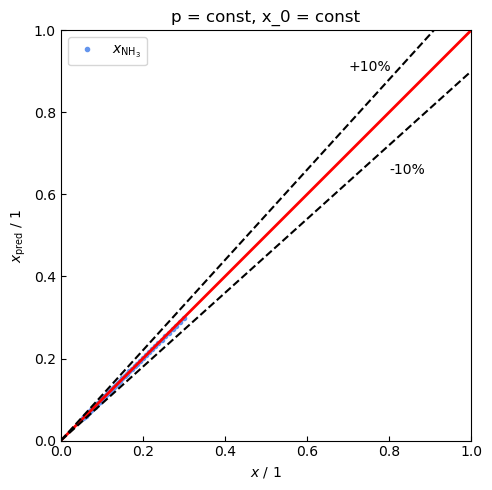

In [7]:
x_NH3_real_norm = y_norm.numpy()
_, x_NH3_pred_norm = (pred.detach().numpy()).T

x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(5,5))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const

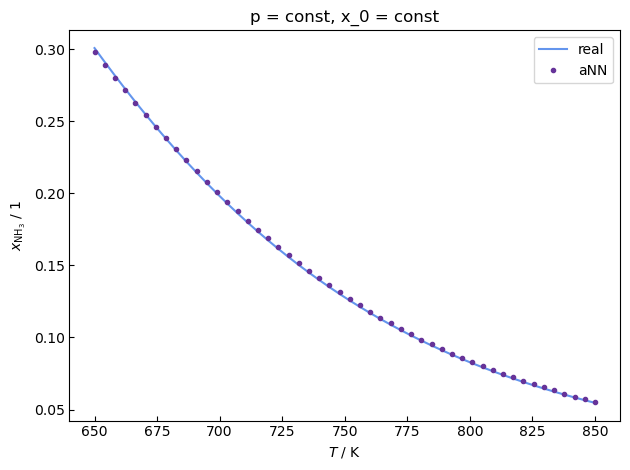

In [8]:
fig,ax = plt.subplots()

ax.plot(X[:,0], x_NH3_real, '-', color ='cornflowerblue', label = 'real')
ax.plot(X[:,0], x_NH3_pred, '.', color ='rebeccapurple', label = 'aNN')
ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

### Extrapolation

#### Laden und Preprocessing der GGW-Daten

In [9]:
# Daten Extrapolation
eq_data_file_extra = Path.cwd().parent / 'data' / 'eq_dataset_x_extra.npz' #Import der GGW Daten
extra_data = np.load(eq_data_file_extra)

# Standardisierungsdaten
norm_data_file = Path.cwd().parent / 'data' / 'models' / 'params_005_020.npz'
norm_data = np.load(norm_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2, NH3]
T = torch.tensor(extra_data['T'])
p = torch.tensor(extra_data['p'])
x_0 = torch.tensor(extra_data['x_0'])
x = torch.tensor(extra_data['x'])

X = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

mean_in = torch.tensor(norm_data['mean_in'])
mean_out = torch.tensor(norm_data['mean_out'])
std_in = torch.tensor(norm_data['std_in'])
std_out = torch.tensor(norm_data['std_out'])

X_norm = (X - mean_in) / std_in
y_norm = (y - mean_out) / std_out

# print(y)
# print(y_norm)

#### Vorhersage der GGW-Daten

In [10]:
#Vorhersage
pred = net(X_norm)

#### Auswertung der Extrapolation - Parity Plot

Training Dataset: R^2(H2) = 0.9656722300398104 , R^2(NH3) = 0.8801669891022886
Max Error Training: |x_H2 - x_H2,pred| = 0.11729717321497846 , |x_NH3 - x_NH3,pred| = 0.15760338817419883


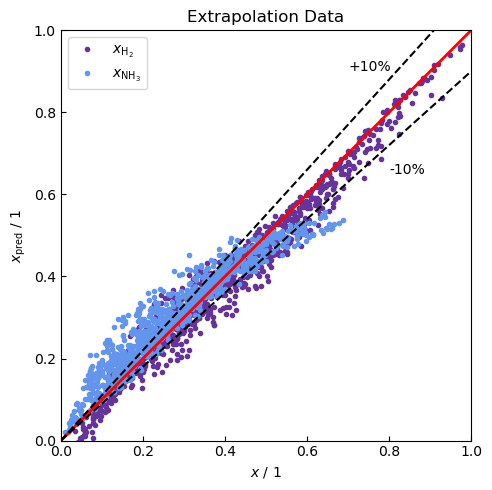

In [11]:
x_H2_real_norm = y_norm[:,0].numpy()
x_NH3_real_norm = y_norm[:,1].numpy()
x_H2_pred_norm, x_NH3_pred_norm = (pred.detach().numpy()).T

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(5,5))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('Extrapolation Data')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [12]:
print(X)
print(y * std_out + mean_out)
x_H2, x_NH3 = (net(X).detach().numpy()).T
print(x_H2 * std_out[0].numpy() + mean_out[0].numpy(), ', ', x_NH3 * std_out[1].numpy() + mean_out[1].numpy())

tensor([[5.7926e+02, 3.6556e+01, 7.1867e-02, 2.2468e-01, 7.0345e-01],
        [6.0203e+02, 7.5556e+01, 8.7265e-02, 3.7796e-01, 5.3477e-01],
        [5.5540e+02, 7.7128e+01, 9.9201e-02, 6.1530e-01, 2.8550e-01],
        ...,
        [6.4087e+02, 2.4653e+01, 1.3993e-01, 4.0754e-01, 4.5253e-01],
        [5.3499e+02, 3.7356e+01, 4.4761e-01, 4.8955e-01, 6.2847e-02],
        [5.6952e+02, 5.2022e+01, 8.3093e-01, 1.3679e-01, 3.2284e-02]])
tensor([[0.5564, 0.1825],
        [0.5357, 0.1827],
        [0.5039, 0.1786],
        ...,
        [0.5669, 0.1656],
        [0.5164, 0.1837],
        [0.5996, 0.1850]])
[35.25255326 35.9642775  33.04653142 33.98353779 32.34912413 32.9415228
 37.38103125 31.74495591 34.84041701 33.89387337 32.30217174 39.03445539
 31.61602396 30.7615406  38.56593242 39.43576235 32.12623236 31.22688897
 31.94999284 35.09548467 33.61689722 36.47950689 33.37593954 37.46271516
 30.6306217  31.66937267 39.22843547 33.24777746 37.6592699  38.64763188
 30.420293   31.60280128 31.3203